In [1]:
import random

import numpy as np
import torch
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy import select

#from network.models import MashVAE
from network.convert_recipe import build_grain_type_lookup_maps, build_core_grain_type_lookup_maps, convert_recipe_numpy, NUM_GRAIN_SLOTS
from db_scripts.brewbrain_db import BREWBRAIN_DB_ENGINE_STR, Base, Grain, CoreGrain, RecipeML

TRAINING_SET_PCT = 0.75
TESTING_SET_PCT  = 1.0 - TRAINING_SET_PCT

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [20]:
engine = create_engine(BREWBRAIN_DB_ENGINE_STR, echo=False, future=True)
Base.metadata.create_all(engine)

# Build a map of recipes converted to a form that's easy to turn into tensors / feed to our network
converted_recipes = {}
with Session(engine) as session:
  grains_db = session.scalars(select(Grain)).all()
  core_grains_db = session.scalars(select(CoreGrain)).all()
  grains_dbid_to_idx, grains_idx_to_dbid = build_grain_type_lookup_maps(grains_db)
  core_grains_dbid_to_idx, core_grains_idx_to_dbid = build_core_grain_type_lookup_maps(core_grains_db)

  # Split into training, validation, test sets
  recipes_db = session.scalars(select(RecipeML)).all()
  converted_recipes = convert_recipe_numpy(recipes_db, grains_dbid_to_idx, core_grains_dbid_to_idx)
  random.shuffle(converted_recipes)

  training_size = int(TRAINING_SET_PCT*len(converted_recipes))
  training_recipes = converted_recipes[:training_size]
  test_recipes     = converted_recipes[training_size:]

In [4]:
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import select
from db_scripts.brewbrain_db import BREWBRAIN_DB_ENGINE_STR, Base, Grain, CoreGrain, RecipeML

engine = create_engine(BREWBRAIN_DB_ENGINE_STR, echo=False, future=True)
Base.metadata.create_all(engine)
with Session(engine) as session:
  print(session.scalars(select(CoreGrain.id)).all())

  

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


In [6]:
def layer_init_ortho(layer, std=np.sqrt(2)):
  nn.init.orthogonal_(layer.weight, std)
  nn.init.constant_(layer.bias, 0.0)
  return layer

def layer_init_xavier(layer, nonlinearity='relu', param=0):
  nn.init.xavier_normal_(layer.weight, nn.init.calculate_gain(nonlinearity, param))
  nn.init.constant_(layer.bias, 0.0)
  return layer

def reparameterize(mu, logvar):
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  return eps * std + mu

***Mash Amounts VAE Testing***

In [37]:
LEAKY_RELU_SLOPE = 0.1
HIDDEN_SIZE = 64
Z_SIZE = 8
enc1 = layer_init_xavier(nn.Linear(NUM_GRAIN_SLOTS, HIDDEN_SIZE), 'leaky_relu', LEAKY_RELU_SLOPE)
enc2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, 2*Z_SIZE), 'linear')
dec1 = layer_init_xavier(nn.Linear(Z_SIZE, HIDDEN_SIZE), 'leaky_relu', LEAKY_RELU_SLOPE)
dec2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, NUM_GRAIN_SLOTS), 'tanh')

GAMMA = 1000.0
MAX_CAPACITY = 25
C_STOP_ITER = 1e5
C_max = torch.Tensor([MAX_CAPACITY])
num_iter = 0

def loss_fn(x, x_hat, mean, logvar, num_iter):
  recons_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
  kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim=1), dim=0)
  C = torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0])
  loss = recons_loss + GAMMA * (kl_loss - C).abs() #n_kl_beta * kl_loss
  return loss

optim_params = list(enc1.parameters()) + list(enc2.parameters()) + list(dec1.parameters()) + list(dec2.parameters()) + list(C_max)
optimizer = torch.optim.Adam(optim_params, lr=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5000, eps=1e-6)

In [ ]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

plt.close()
fig, (ax1, ax2, axInOut) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

test_batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=BATCH_SIZE)

#optimizer.param_groups[0]['lr'] = 1e-3
def forward(x, plot=False):
    x = nn.functional.leaky_relu(enc1(x), LEAKY_RELU_SLOPE)
    if plot: ax1.hist(x.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='red', alpha=0.5)
    x = enc2(x)
    mean, logvar = torch.chunk(x, 2, dim=-1)

    if plot:
      ax1.hist(x.flatten().detach().numpy(),      bins=HIDDEN_SIZE, facecolor='blue',  alpha=0.5)
      ax1.hist(mean.flatten().detach().numpy(),   bins=HIDDEN_SIZE, facecolor='magenta',  alpha=0.5)
      ax1.hist(logvar.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='green', alpha=0.5)

    z = reparameterize(mean, logvar)

    x_hat = nn.functional.leaky_relu(dec1(z), LEAKY_RELU_SLOPE)
    if plot: ax2.hist(x_hat.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='red', alpha=0.5)
    x_hat = torch.tanh(dec2(x_hat))
    if plot: ax2.hist(x_hat.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='blue', alpha=0.5)
    return x_hat, mean, logvar

for i in range(NUM_EPOCHS):
  for batch_idx, batch_data in enumerate(test_batch_loader):
    show_graphs = i == NUM_EPOCHS-1 and batch_idx == BATCH_SIZE-1 
    x = (batch_data['amts'] - 0.5) * 2.0 # Normalize to [0,1]
    x_hat, mean, logvar = forward(x, show_graphs)
    if show_graphs:
      #idx = random.randint(0,BATCH_SIZE-1)
      axInOut.hist(x.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='cyan', alpha=0.5)
      axInOut.hist(x_hat.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='magenta', alpha=0.5)

    num_iter += 1
    loss = loss_fn(x, x_hat, mean, logvar, num_iter)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    if batch_idx % 100 == 0: print(f"Loss: {loss.item()}, lr: {optimizer.param_groups[0]['lr']}, C: {torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0]).item()}")

print(f"Loss: {loss.item()}")
plt.show()

In [ ]:
plt.close()
fig, (ax1, ax2, axInOut) = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

data = next(iter(test_batch_loader))
with torch.no_grad():
  x = (data['amts'] - 0.5) * 2.0
  x_hat, mean, logvar = forward(x, True)
  
  axInOut.hist(x.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='cyan', alpha=0.5)
  axInOut.hist(x_hat.flatten().detach().numpy(), bins=NUM_GRAIN_SLOTS, facecolor='magenta', alpha=0.5)

  for i in range(x.shape[0]):
    print(torch.round(x[i]/2.0 + 0.5, decimals=3))

    denorm_x_hat = (x_hat[i]/2.0 + 0.5)
    denorm_x_hat[denorm_x_hat < 0.01] = 0.0
    print(torch.round(denorm_x_hat / torch.sum(denorm_x_hat), decimals=3))

***Mash Types VAE Testing***

In [155]:
LEAKY_RELU_SLOPE = 0.1
HIDDEN_SIZE = 256 # 232 is good (200 epochs results in 0.23% error), 200 is not enough to get reconstruction loss < 1
Z_SIZE = 44 # Depends on fidelity you want.. 32 will get within 14% error at the mean. Higher is better up to the point of memorizing the data
GRAIN_TYPE_EMBED_SIZE = 32 # Embedding needs to be ~20, NOTE: 16 is too low for 62 malt types and results in confusion around some malts
NUM_CORE_GRAIN_TYPES = len(core_grains_idx_to_dbid) # Currently this is ~62

type_embedding = nn.Embedding(NUM_CORE_GRAIN_TYPES, GRAIN_TYPE_EMBED_SIZE)
enc1 = layer_init_xavier(nn.Linear(NUM_GRAIN_SLOTS*GRAIN_TYPE_EMBED_SIZE, HIDDEN_SIZE), 'linear', LEAKY_RELU_SLOPE)
enc2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, 2*Z_SIZE), 'linear')
batch_norm = nn.BatchNorm1d(2*Z_SIZE)
dec1 = layer_init_xavier(nn.Linear(Z_SIZE, HIDDEN_SIZE), 'linear', LEAKY_RELU_SLOPE)
dec2 = layer_init_xavier(nn.Linear(HIDDEN_SIZE, NUM_GRAIN_SLOTS*GRAIN_TYPE_EMBED_SIZE), 'linear', LEAKY_RELU_SLOPE)
type_decoder = layer_init_xavier(nn.Linear(GRAIN_TYPE_EMBED_SIZE, NUM_CORE_GRAIN_TYPES), 'linear')

GAMMA = 1000.0
MAX_CAPACITY = 25
C_STOP_ITER = 1e5
C_max = torch.Tensor([MAX_CAPACITY])
num_iter = 0

optim_params = list(type_embedding.parameters()) + list(enc1.parameters()) + list(enc2.parameters()) + list(dec1.parameters()) + list(dec2.parameters()) + list(type_decoder.parameters()) + list(C_max) + list(batch_norm.parameters())
optimizer = torch.optim.Adam(optim_params, lr=1e-3, betas=(0.9, 0.999))

In [200]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4000, eps=1e-5) # Patience is in epochs!
optimizer.param_groups[0]['lr'] = 1e-3 # Learning Rate
#num_iter = 0

 Loss: 35.22894 lr: 1e-05 C: 25.0 			
 Avg Epoch #1 loss: 21.14				
 Loss: 24.53659 lr: 1e-05 C: 25.0 			
 Avg Epoch #2 loss: 21.02638				
 Loss: 15.71714 lr: 1e-05 C: 25.0 		

KeyboardInterrupt: 

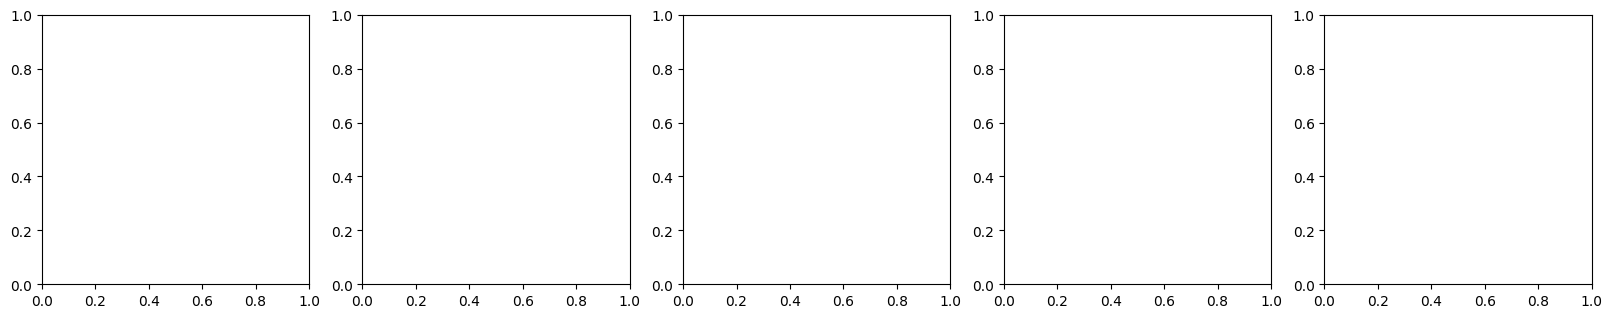

In [203]:
# NOTE: Best way to train is to set the KL_WEIGHT to 1 and train down as low as you can go in about 500 epochs, then
# set the KL_WEIGHT to 0 and train to a loss of < 1 then retrain back and forth like this until satisfied
NUM_EPOCHS = 100
BATCH_SIZE = 32
KL_WEIGHT  = 0.5
JUST_USE_MEAN = False

test_batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=BATCH_SIZE)
num_batches = len(test_batch_loader)
plt.close()

fig, (ax1, ax2, ax3, ax4, axInOut) = plt.subplots(1, 5)
fig.set_size_inches(20, 3.5)

def loss_fn(x, x_hat, mean, logvar, num_iter, kl_weight=1.0):
  one_hot_types = nn.functional.one_hot(x.long(), NUM_CORE_GRAIN_TYPES).float()
  recons_loss = nn.functional.binary_cross_entropy_with_logits(x_hat, one_hot_types, reduction='sum')
  kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim=1), dim=0)
  C = torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0])
  loss = recons_loss + kl_weight * GAMMA * (kl_loss - C).abs() #n_kl_beta * kl_loss
  return loss

def decode(z, plot=False):
  x_hat = nn.functional.elu(dec1(z))#, LEAKY_RELU_SLOPE)
  if plot: ax3.hist(x_hat.flatten().detach().numpy(), bins=32, facecolor='red', alpha=0.5)
  x_hat = nn.functional.elu(dec2(x_hat))#, LEAKY_RELU_SLOPE)
  if plot: ax3.hist(x_hat.flatten().detach().numpy(), bins=32, facecolor='blue', alpha=0.5)

  # Decode the types
  x_hat = type_decoder(x_hat.view(-1, NUM_GRAIN_SLOTS, GRAIN_TYPE_EMBED_SIZE)) # Shape: (B, NUM_GRAIN_SLOTS, GRAIN_TYPE_EMBED_SIZE)
  if plot: ax4.hist(x_hat.flatten().detach().numpy(), bins=HIDDEN_SIZE, facecolor='red', alpha=0.5)

  return x_hat

def forward(x, use_mean=False, plot=False):
  # Encode the types
  embed_types = type_embedding(x).flatten(1)

  x = nn.functional.elu(enc1(embed_types))#, LEAKY_RELU_SLOPE)
  if plot: ax1.hist(x.flatten().detach().numpy(), bins=64, facecolor='red', alpha=0.5)
  
  x = enc2(x)
  if plot: ax1.hist(x.flatten().detach().numpy(), bins=64, facecolor='blue',  alpha=0.5)
  x = batch_norm(x)
  if plot: ax1.hist(x.flatten().detach().numpy(), bins=64, facecolor='green',  alpha=0.75)

  mean, logvar = torch.chunk(x, 2, dim=-1)

  if plot:
    ax2.hist(mean.flatten().detach().numpy(),   bins=Z_SIZE, facecolor='magenta', alpha=0.5)
    ax2.hist(logvar.flatten().detach().numpy(), bins=Z_SIZE, facecolor='cyan', alpha=0.5)
  
  z = mean if use_mean else reparameterize(mean, logvar)
  return decode(z, plot=plot), mean, logvar


outlier_batches = []
batch_losses = []
epoch_avg_losses = []
for i in range(NUM_EPOCHS):

  batch_loss_sum = 0
  num_batch_losses = 0
  for batch_idx, batch_data in enumerate(test_batch_loader):
    show_graphs = i == NUM_EPOCHS-1 and batch_idx == num_batches-1 
    x = batch_data['core_types'] # Type ID of the core grain type [0, NUM_CORE_GRAIN_TYPES)
    x_hat, mean, logvar = forward(x, use_mean=JUST_USE_MEAN, plot=show_graphs)

    if show_graphs:
      axInOut.hist(x.flatten().detach().numpy(), bins=NUM_CORE_GRAIN_TYPES, facecolor='cyan', alpha=0.5)
      axInOut.hist(torch.argmax(torch.softmax(x_hat, dim=-1), dim=-1).flatten().detach().numpy(), bins=NUM_CORE_GRAIN_TYPES, facecolor='magenta', alpha=0.5)

    loss = loss_fn(x, x_hat, mean, logvar, num_iter, kl_weight=KL_WEIGHT)
    batch_losses.append(loss.item())
    batch_loss_sum += loss.item()
    num_batch_losses += 1
    if KL_WEIGHT == 0 and BATCH_SIZE == 1 and NUM_EPOCHS == 1 and loss.item() > 100:
      outlier_batches.append((batch_data,loss.item()))

    if not JUST_USE_MEAN:
      num_iter += 1

    optimizer.zero_grad() 
    loss.backward()
    nn.utils.clip_grad_norm_(optim_params, 10.0)
    optimizer.step()
    scheduler.step(loss)
    print('\r', "Loss:", np.around(loss.item(), 5), "lr:", optimizer.param_groups[0]['lr'], "C:", np.around(torch.clamp(C_max/C_STOP_ITER * num_iter, 0, C_max.data[0]).item(),1), "\t\t", end='')

  epoch_avg_loss = batch_loss_sum / num_batch_losses
  epoch_avg_losses.append(epoch_avg_loss)
  
  print("\r\n", f"Avg Epoch #{i+1} loss: {np.around(epoch_avg_loss,5)}\t\t\t\t")

fig2, lossesAx = plt.subplots(1, 1)
lossesAx.plot(list(range(1,len(batch_losses)+1)), batch_losses, c='cyan', alpha=0.5)
lossesAx.plot(list(range(1,len(batch_losses)+1, num_batches)), epoch_avg_losses, c='magenta')

plt.show()

In [65]:
def get_malt_names_from_inds_tensor(inds_tensor):
  malt_names = []
  for idx_t in inds_tensor:
    idx = idx_t.item()
    if idx == 0:
      continue
    grain = next(filter(lambda x: x.id == core_grains_idx_to_dbid[idx], core_grains_db))
    malt_names.append(grain.name)
  return malt_names

print(f"{len(outlier_batches)} outliers found:")
for outlier, loss in outlier_batches:
  x = outlier['core_types']
  print(f"Recipe ID: {outlier['recipe_id'].item()}, Loss: {loss}, Malt Bill: {get_malt_names_from_inds_tensor(x[0])}") 

print([outlier['recipe_id'].item() for outlier, _ in outlier_batches])

0 outliers found:
[]


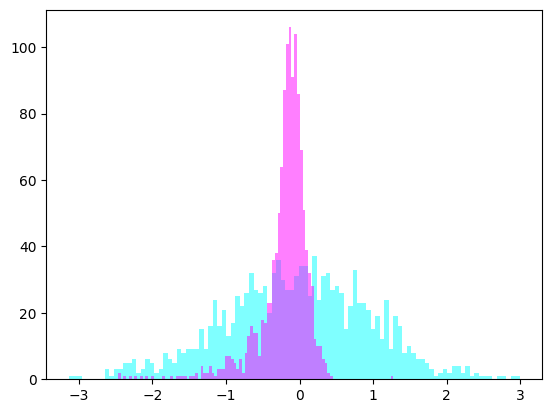

In [91]:
plt.close()
plt.hist(type_embedding.weight.detach().flatten().numpy(), bins=100, facecolor='cyan', alpha=0.5)
plt.hist(type_decoder.weight.detach().flatten().numpy(), bins=100, facecolor='magenta', alpha=0.5)
plt.show()

Mismatch for recipe id 29147
Input:  ['Pale (2-Row) Malt', 'Crystal Malt (~20-40L)', 'Crystal Malt (~5-20L)', 'Victory/Biscuit/Honey/Melanoidin Malt', 'Victory/Biscuit/Honey/Melanoidin Malt']
Output: ['Pale (2-Row) Malt', 'Dextrine Malt', 'Crystal Malt (~5-20L)', 'Victory/Biscuit/Honey/Melanoidin Malt', 'Victory/Biscuit/Honey/Melanoidin Malt']
Mismatch for recipe id 7052
Input:  ['Pale Ale Malt', 'Crystal Malt (~40-60L)']
Output: ['Pale Ale Malt', 'Flaked/Torrefied Barley']
Found mismatches: 2 / 27882 (0.01%)


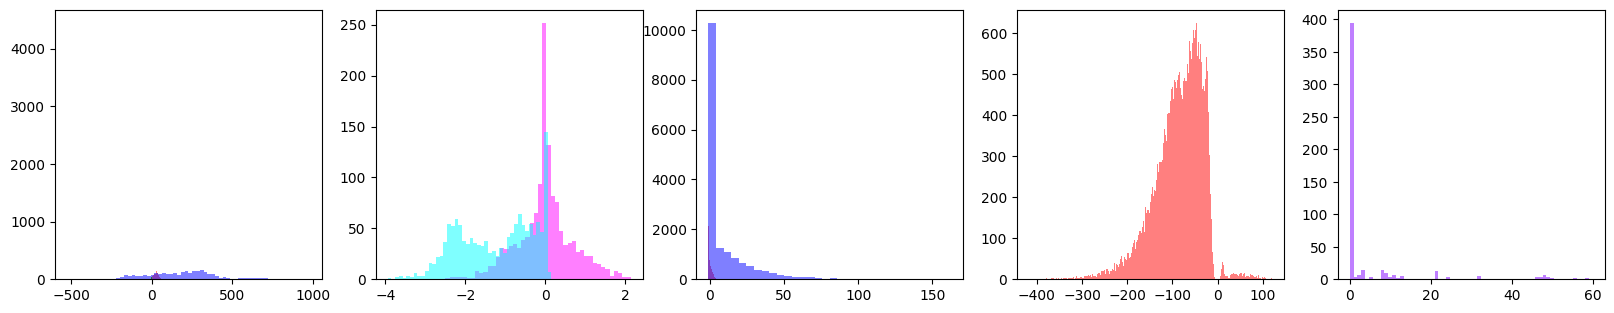

In [202]:
plt.close()

fig, (ax1, ax2, ax3, ax4, axInOut) = plt.subplots(1, 5)
fig.set_size_inches(20, 3.5)

def get_malt_names_from_inds_tensor(inds_tensor):
  malt_names = []
  for idx_t in inds_tensor:
    idx = idx_t.item()
    if idx == 0:
      continue
    grain = next(filter(lambda x: x.id == core_grains_idx_to_dbid[idx], core_grains_db))
    malt_names.append(grain.name)
  return malt_names

def print_malt_bill_comparisons(x, x_hat_types):
  print(f"Input:  {get_malt_names_from_inds_tensor(x[i])}")
  print(f"Output: {get_malt_names_from_inds_tensor(x_hat_types[i])}")

data = next(iter(test_batch_loader))
with torch.no_grad():
  x = data['core_types']
  x_hat, mean, logvar = forward(x, use_mean=True, plot=True)
  x_hat_types = torch.argmax(torch.softmax(x_hat, dim=-1), dim=-1)
  axInOut.hist(x.flatten().detach().numpy(), bins=NUM_CORE_GRAIN_TYPES, facecolor='cyan', alpha=0.5)
  axInOut.hist(x_hat_types.flatten().detach().numpy(), bins=NUM_CORE_GRAIN_TYPES, facecolor='magenta', alpha=0.5)

  #for i in range(BATCH_SIZE):
  #  x_malts = get_malt_names_from_inds_tensor(x[i])
  #  x_hat_malts = get_malt_names_from_inds_tensor(x_hat_types[i])
  #  print(f"Input:  {x_malts}")
  #  print(f"Output: {x_hat_malts}")

  # Perform a full check for identity between input and output of the network
  mismatch_count = 0
  total_count = 0
  for batch_idx, batch_data in enumerate(test_batch_loader):
    x = batch_data['core_types']
    x_hat, mean, logvar = forward(x, use_mean=True, plot=False)
    x_hat_types = torch.argmax(torch.softmax(x_hat, dim=-1), dim=-1)
    for i in range(x.shape[0]):
      total_count += 1
      if not torch.equal(x[i].int(), x_hat_types[i].int()):
        print(f"Mismatch for recipe id {batch_data['recipe_id'][i].item()}")
        print_malt_bill_comparisons(x, x_hat_types)
        mismatch_count += 1

  print(f"Found mismatches: {mismatch_count} / {total_count} ({mismatch_count/total_count * 100:.2f}%)")

In [206]:
# Let's try generating a random latent vector (z) and see what kinds of malt types we can create from noise!
NUM_RAND_MALT_BILLS = 8
with torch.no_grad():
  z = torch.randn(NUM_RAND_MALT_BILLS, Z_SIZE)
  x_hat = decode(z)
  x_hat_types = torch.argmax(torch.softmax(x_hat, dim=-1), dim=-1)
  for i in range(z.shape[0]):
    print(get_malt_names_from_inds_tensor(x_hat_types[i]))



['Pale Ale Malt', 'Acidulated/Sour Malt', 'Dextrine Malt', 'Vienna Malt']
['Pale (2-Row) Malt', 'Crystal Malt (~20-40L)']
['Pale Ale Malt', 'Pilsner Malt', 'Chocolate Malt']
['Pilsner Malt', 'Victory/Biscuit/Honey/Melanoidin Malt', 'Roasted Wheat Malt']
['Pilsner Malt', 'Wheat Malt', 'Flaked/Rolled Oats']
['Pale (2-Row) Malt', 'Pale Ale Malt', 'Flaked/Rolled Oats', 'Crystal Malt (~80-120L)']
['Pale Ale Malt', 'Crystal Malt (~80-120L)', 'Dextrine Malt', 'Acidulated/Sour Malt', 'Chocolate Malt']
['Pale Ale Malt', 'Black Malt', 'Crystal Malt (~120-180L)', 'Crystal Munich', 'Flaked/Torrefied Wheat']


In [156]:

class MashVAE(nn.Module):
  def __init__(self, num_grain_types, num_grain_slots, hidden_size, z_size) -> None:
    super().__init__()
    GRAIN_EMBED_SIZE = 128

    self.num_grain_slots = num_grain_slots
    self.num_grain_types = num_grain_types

    self.grain_type_embed = nn.Embedding(num_grain_types, GRAIN_EMBED_SIZE)
    self.input_size = (GRAIN_EMBED_SIZE + 1) * num_grain_slots # type embed (embed size floats) + percentage of the mass (1 float)
    self.encoder = nn.Sequential(
      layer_init_ortho(nn.Linear(self.input_size, hidden_size)),
      nn.LeakyReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, 2*z_size))
    )
    self.decoder = nn.Sequential(
      layer_init_ortho(nn.Linear(z_size, hidden_size)),
      nn.LeakyReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, self.input_size)),
    )
    self.type_decoder = layer_init_ortho(nn.Linear(GRAIN_EMBED_SIZE, num_grain_types))

    #LOGVAR_INIT = 0.0
    #self.logvar = nn.Parameter(torch.ones(size=()) * LOGVAR_INIT)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var) # standard deviation
    eps = torch.randn_like(std) # `randn_like` as we need the same size
    sample = mu + (eps * std) # sampling as if coming from the input space
    return sample

  def encode(self, x):
    h = self.encoder(x)
    mu, logvar = torch.chunk(h, 2, dim=-1)
    return mu, logvar

  def decode(self, z):
    x_hat = self.decoder(z)
    type_x_hats, amt_x_hats = torch.split(x_hat, (self.num_grain_slots * self.grain_type_embed.embedding_dim, self.num_grain_slots), dim=-1)

    category_x_hats = self.type_decoder(type_x_hats.view(z.shape[0],self.num_grain_slots,-1))
    amt_x_hats = torch.sigmoid(amt_x_hats.view(z.shape[0],self.num_grain_slots,-1))

    return category_x_hats, amt_x_hats

  def forward(self, batch_mashes, sample_posterior=True):
    # batch_mashes is a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    embed_types = self.grain_type_embed(batch_mashes[0]).view(batch_mashes[0].shape[0], -1)
    x = torch.cat([embed_types, batch_mashes[1]], dim=-1)
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar) if sample_posterior else mu

    category_reconst, amount_reconst = self.decode(z)
    return category_reconst, amount_reconst, (mu, logvar)

  def loss(self, batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.1):
    # batch_mashes is the original input to the network, 
    # it's a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    
    # Break the reconstructions up to get the types and amounts
    #one_hot_cats = nn.functional.one_hot(batch_mashes[0].long(), self.num_grain_types).float()
    #cat_reconst_loss = nn.functional.binary_cross_entropy_with_logits(category_reconsts, one_hot_cats, reduction='sum')
    #cat_reconst_loss /= category_reconsts.shape[0]
    cat_reconst_loss = torch.zeros((1,))

    amt_reconst_loss = nn.functional.mse_loss(amount_reconsts, batch_mashes[1].unsqueeze(-1), reduction='sum')

    mu, logvar = posteriors
    kl_loss = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())

    total_loss = cat_reconst_loss + amt_reconst_loss + kl_weight * kl_loss

    return total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss


'''
class DiagonalGaussianDistribution(object):
  def __init__(self, parameters):
    self.parameters = parameters
    self.mean, self.logvar = torch.chunk(parameters, 2, dim=-1)
    self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
    self.std = torch.exp(0.5 * self.logvar)
    self.var = torch.exp(self.logvar)

  def sample(self):
    x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
    return x

  def kl(self, other=None):
    if other is None:
      return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=-1)
    else:
      return 0.5 * torch.sum(torch.pow(self.mean - other.mean, 2) / other.var + self.var / other.var - 1.0 - self.logvar + other.logvar, dim=-1)

  def nll(self, sample):
    LOG_TWO_PI = np.log(2.0 * np.pi)
    return 0.5 * torch.sum(LOG_TWO_PI + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=-1)

  def mode(self): return self.mean


class MashVAE(nn.Module):
  def __init__(self, num_grain_types, num_grain_slots, hidden_size, z_size) -> None:
    super().__init__()
    GRAIN_EMBED_SIZE = 128

    self.num_grain_slots = num_grain_slots
    self.num_grain_types = num_grain_types

    self.grain_type_embed = nn.Embedding(num_grain_types, GRAIN_EMBED_SIZE)
    self.input_size = (GRAIN_EMBED_SIZE + 1) * num_grain_slots # type embed (embed size floats) + percentage of the mass (1 float)
    self.encoder = nn.Sequential(
      layer_init_ortho(nn.Linear(self.input_size, hidden_size)),
      nn.ReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, 2*z_size))
    )
    self.decoder = nn.Sequential(
      layer_init_ortho(nn.Linear(z_size, hidden_size)),
      nn.ReLU(inplace=True),
      layer_init_ortho(nn.Linear(hidden_size, self.input_size)),
    )
    self.type_decoder = layer_init_ortho(nn.Linear(GRAIN_EMBED_SIZE, num_grain_types))

    #LOGVAR_INIT = 0.0
    #self.logvar = nn.Parameter(torch.ones(size=()) * LOGVAR_INIT)

  def encode(self, x):
    h = self.encoder(x)
    posterior = DiagonalGaussianDistribution(h)
    return posterior

  def decode(self, z):
    x_hat = self.decoder(z)
    type_x_hats, amt_x_hats = torch.split(x_hat, (self.num_grain_slots * self.grain_type_embed.embedding_dim, self.num_grain_slots), dim=-1)

    category_x_hats = self.type_decoder(type_x_hats.view(z.shape[0],self.num_grain_slots,-1))
    amt_x_hats = amt_x_hats.view(z.shape[0],self.num_grain_slots,-1)

    return category_x_hats, amt_x_hats

  def forward(self, batch_mashes, sample_posterior=True):
    # batch_mashes is a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    embed_types = self.grain_type_embed(batch_mashes[0]).view(batch_mashes[0].shape[0], -1)
    x = torch.cat([embed_types, batch_mashes[1]], dim=-1)
    posterior = self.encode(x)
    z = posterior.sample() if sample_posterior else posterior.mode()
    category_reconst, amount_reconst = self.decode(z)
    return category_reconst, amount_reconst, posterior

  def loss(self, batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.1):
    # batch_mashes is the original input to the network, 
    # it's a tuple (type_indices, amount_percentages), shape is ((B, num_grain_slots), (B, num_grain_slots))
    
    # Break the reconstructions up to get the types and amounts
    #one_hot_cats = nn.functional.one_hot(batch_mashes[0].long(), self.num_grain_types).float()
    #cat_reconst_loss = nn.functional.binary_cross_entropy_with_logits(category_reconsts, one_hot_cats, reduction='sum')
    #cat_reconst_loss /= category_reconsts.shape[0]
    cat_reconst_loss = torch.zeros((1,))

    amt_reconst_loss = nn.functional.mse_loss(amount_reconsts, batch_mashes[1].unsqueeze(-1), reduction='sum')
    amt_reconst_loss /= amount_reconsts.shape[0]
    #amt_reconst_loss = torch.abs(amount_reconsts - batch_mashes[1].unsqueeze(-1))
    #nll_loss = amt_reconst_loss / torch.exp(self.logvar) + self.logvar
    #amt_reconst_loss = torch.sum(nll_loss) / nll_loss.shape[0]

    # Calculate the KL loss
    kl_loss = posteriors.kl()
    kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

    total_loss = cat_reconst_loss + amt_reconst_loss + kl_weight * kl_loss

    return total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss
'''

num_grain_types = len(grains_idx_to_dbid)
mash_vae = MashVAE(num_grain_types, NUM_GRAIN_SLOTS, 512, 1024)
optim_params = list(mash_vae.parameters())# + list(loss_fn.parameters())
optimizer = torch.optim.Adam(optim_params)

def build_batch_tensors_tuple(samples):
  batch_grain_types = []
  batch_grain_amts  = []
  for recipe_mash in samples:
    batch_grain_types.append(torch.tensor(recipe_mash['type_inds'], dtype=torch.long))
    batch_grain_amts.append(torch.tensor(recipe_mash['amts'], dtype=torch.float))
  return (torch.stack(batch_grain_types), torch.stack(batch_grain_amts))

In [ ]:
# Training
NUM_EPOCHS = 100
BATCH_SIZE = 128

optimizer.param_groups[0]['lr'] = 1e-5 # Learning Rate

batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=BATCH_SIZE)

mash_vae.train()
for epoch in range(NUM_EPOCHS):
  print(f"Epoch {epoch+1}...")
  for batch_idx, batch_samples in enumerate(batch_loader):

    #rndInds = np.random.choice(range(len(training_recipes)), (BATCH_SIZE), replace=False)
    #batch_mashes = build_batch_tensors_tuple(training_recipes, rndInds)
    batch_mashes = (batch_samples['type_inds'], batch_samples['amts'])
    
    category_reconsts, amount_reconsts, posteriors = mash_vae(batch_mashes)
    total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss = mash_vae.loss(batch_mashes, category_reconsts, amount_reconsts, posteriors, kl_weight=0.6)

    optimizer.zero_grad()
    total_loss.backward()
    nn.utils.clip_grad_norm_(optim_params, 0.5)
    optimizer.step()

    if batch_idx % 10 == 0:
      print(f"[Batch: {batch_idx+1}]: loss={total_loss.item()}, grain amounts loss={amt_reconst_loss.item()}, grain types loss={cat_reconst_loss.item()}, kl_loss={kl_loss.item()}")

  optimizer.param_groups[0]['lr'] /= 2.0
print("Training finished.")

In [ ]:
TEST_BATCH_SIZE   = 32

test_batch_loader = torch.utils.data.DataLoader(training_recipes, batch_size=TEST_BATCH_SIZE)
mash_vae.eval()
with torch.no_grad():
  # See how the network fairs against the training set
  for batch_idx, batch_samples in enumerate(test_batch_loader):
    
    test_batch_mashes = (batch_samples['type_inds'], batch_samples['amts'])
   
    category_reconsts, amount_reconsts, posteriors = mash_vae(test_batch_mashes, sample_posterior=True)
    total_loss, amt_reconst_loss, cat_reconst_loss, kl_loss = mash_vae.loss(test_batch_mashes, category_reconsts, amount_reconsts, posteriors)
    print(f"[{batch_idx+1}]: loss={total_loss.item()}, grain amounts loss={amt_reconst_loss.item()}, grain types loss={cat_reconst_loss.item()}, kl_loss={kl_loss.item()}")

    # What does a malt bill look like - original vs. decoded...
    CHECK_IDX = 0
    type_inds = test_batch_mashes[0][CHECK_IDX].cpu().numpy()
    amts = test_batch_mashes[1][CHECK_IDX].cpu().numpy()

    #print(f"Original - Types: {type_inds}, Amounts: {amts}")
    print(f"Original  - Amounts: {amts.round(3)}")

    type_inds = nn.functional.softmax(category_reconsts[CHECK_IDX], dim=0)
    type_inds = torch.argmax(type_inds, dim=1, keepdim=True).flatten()

    #decoded = {'type_inds': type_inds.cpu().numpy(), 'amts': nn.functional.softmax(amount_reconsts[0], dim=0).flatten().cpu().numpy()}
    #print(f"Decoded  - Types: {decoded['type_inds'].astype(np.int32).tolist()}, Amounts: {decoded['amts'].tolist()}")
    print(f"Decoded  - Amounts: {amount_reconsts[0].flatten().cpu().numpy().round(3)}")


